### 0. Introduction

In [ ]:
pip install -r requirements.txt

In [1]:
# IMPORT LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, label_binarize, StandardScaler
from geopy.geocoders import Nominatim
from concurrent.futures import ThreadPoolExecutor
from sklearn.neighbors import NearestNeighbors
import plotly.express as px
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit, cross_validate, cross_val_score, cross_val_predict, train_test_split, cross_val_predict, KFold, learning_curve
from scipy.stats import randint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pickle
import time
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from itertools import product
import random

In [3]:
# IMPORTS DATA

data = pd.read_excel("Road Accident Data.xlsx")
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

### 1. EDA and Preprocessing

In [4]:
print(data.shape)

X = data.drop("Accident_Severity", axis=1)
y = data["Accident_Severity"]

(307973, 23)


Before starting EDA, in order to avoid Data Leakage, we are going to split our dataset in 4 parts:

X_train and y_train, which contains, respectively, train features and train target.

X_test and y_test, which contains, respectively, test features and test target.

X_test and y_test will be completely isolated, which means their samples are not going to be shown. However, we will have to apply modifications to them.

We are going to reserve 10% of global data (aproximately 31.000 samples) to test our models.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
print(X_train.head())
print(y_train.head())

       Accident_Index Accident Date Month Day_of_Week  Year  \
211637  200943P075049    2021-04-11   Apr    Saturday  2021   
139517  2010000000000    2021-01-29   Jan    Thursday  2021   
195591  201045WA48827    2022-02-19   Feb      Friday  2022   
183720  201022F002174    2022-04-30   Apr      Friday  2022   
34774   2010000000000    2022-10-17   Oct      Sunday  2022   

                    Junction_Control                      Junction_Detail  \
211637  Data missing or out of range  Not at junction or within 20 metres   
139517  Data missing or out of range  Not at junction or within 20 metres   
195591      Give way or uncontrolled              T or staggered junction   
183720      Give way or uncontrolled              T or staggered junction   
34774            Auto traffic signal    More than 4 arms (not roundabout)   

         Latitude       Light_Conditions Local_Authority_(District)  ...  \
211637  52.072892  Darkness - lights lit                   Cherwell  ...   
139517

In [7]:
print("X_train:\n", X_train.describe(), "\n", "\n")
print("y_train:\n", y_train.describe())

X_train:
                        Accident Date           Year       Latitude  \
count                         246378  246378.000000  246378.000000   
mean   2021-12-23 17:37:32.860239360    2021.468715      52.487381   
min              2021-01-01 00:00:00    2021.000000      49.914488   
25%              2021-06-28 00:00:00    2021.000000      51.484892   
50%              2021-12-08 00:00:00    2021.000000      52.222313   
75%              2022-06-25 00:00:00    2022.000000      53.416004   
max              2022-12-31 00:00:00    2022.000000      60.598055   
std                              NaN       0.499021       1.340963   

           Longitude  Number_of_Casualties  Number_of_Vehicles    Speed_limit  
count  246378.000000         246378.000000       246378.000000  246378.000000  
mean       -1.368848              1.356367            1.828463      38.879324  
min        -7.516225              1.000000            1.000000      10.000000  
25%        -2.248878              1.000

In [8]:
print(X_train.dtypes, "\n")
print(y_train.dtype)

Accident_Index                        object
Accident Date                 datetime64[ns]
Month                                 object
Day_of_Week                           object
Year                                   int64
Junction_Control                      object
Junction_Detail                       object
Latitude                             float64
Light_Conditions                      object
Local_Authority_(District)            object
Carriageway_Hazards                   object
Longitude                            float64
Number_of_Casualties                   int64
Number_of_Vehicles                     int64
Police_Force                          object
Road_Surface_Conditions               object
Road_Type                             object
Speed_limit                            int64
Time                                  object
Urban_or_Rural_Area                   object
Weather_Conditions                    object
Vehicle_Type                          object
dtype: obj

It is time to examinate our data to see what preliminary information can we get from it.

Firstly, let's see if there are any NaN in our data.

In [9]:
print("Total number of NaNs in features: " + str(X_train.isna().sum().sum()) + "\n")

print("Total number of NaNs in target: " + str(y_train.isna().sum()) + "\n")

print("Percentage of NaNs by column in features:\n\n" + str(X_train.isna().sum().sort_values()/len(X_train)*100) + "\n\n")

Total number of NaNs in features: 248216

Total number of NaNs in target: 0

Percentage of NaNs by column in features:

Accident_Index                 0.000000
Accident Date                  0.000000
Month                          0.000000
Day_of_Week                    0.000000
Year                           0.000000
Junction_Control               0.000000
Junction_Detail                0.000000
Latitude                       0.000000
Light_Conditions               0.000000
Local_Authority_(District)     0.000000
Longitude                      0.000000
Number_of_Casualties           0.000000
Police_Force                   0.000000
Number_of_Vehicles             0.000000
Urban_or_Rural_Area            0.000000
Speed_limit                    0.000000
Vehicle_Type                   0.000000
Time                           0.005682
Road_Surface_Conditions        0.101064
Road_Type                      0.497203
Weather_Conditions             1.934832
Carriageway_Hazards           98.207226


In [10]:
np.unique(X_train[X_train["Carriageway_Hazards"].notna()]["Carriageway_Hazards"])

array(['Any animal in carriageway (except ridden horse)',
       'Other object on road', 'Pedestrian in carriageway - not injured',
       'Previous accident', 'Vehicle load on road'], dtype=object)

We see that "Carriageway_Hazards" concentrates more than 98% of NaNs, and that can cause a problem, because our models could underestimate the influence of this variable due to its large amount of NaNs.

"A priori", we could think that the objects over the road might have an impact on the severity of the accident, so delete the column can have a negative result.

On the other hand, deleting just the samples that are NaNs would let our dataset with just the 2% of data we currently have, and this sounds even worse. 

Therefore, instead of deleting data, we could consider that a value checked as a "NaN" could just mean that there were no special objects on the road. A prove that backs this hypothesis is that we do not see any "No Object"-like in the unique values of this column (shown just above). So we are going to replace all "NaNs" values of the "Carriageway_Hazards" column with the label "No object", so we can move forward with no NaNs.

Regarding the presence of NaNs in other columns, their percentage is so low that we can just replace them with their mode or mean.

In [11]:
# Remember that we have to apply preprocessing methods to train and test data separately

X_train.fillna({"Carriageway_Hazards": "No object"}, inplace=True)
X_test.fillna({"Carriageway_Hazards": "No object"}, inplace=True) # Just in case there exists NaNs in test data

for column in X_train.columns:
    if X_train[column].isna().sum()>0:
        X_train.fillna({column: X_train[column].mode()[0]}, inplace=True) # We use the mode because all columns with NaNs are categorical
    # We have to apply the same method to test data
    if X_test[column].isna().sum()>0:
        X_test.fillna({column: X_test[column].mode()[0]}, inplace=True)

if (y_test.isna().sum()>0): # In case that our test target data has any NaN (we can not see if that actually happens, because it would cause Data Leakage)
    y_test.fillna(y_test.mode()[0], inplace=True)

"Time" is an important variable that gives us information about the moments of the day when accidents occur the most. As the dataset comes, this variable is codified as a "datetime" object, showing the exact hour, minute and second when the accident was notified. We would prefer to codify this variable, so it shows the period of the day, rather than the exact time.

In [12]:
"""

Early Morning: from 00:00 to 06:00
Sunrise: from 06:00 to 09:00
Morning: from 09:00 to 12:00
Noon: from 12:00 to 14:00
Afternoon: from 14:00 to 18:00
Sunset: from 18:00 to 19:00
Night: from 19:00 to 00:00

"""

def classify_time(time):
    hour = pd.to_datetime(str(time), format='%H:%M:%S').hour
    if hour >= 0 and hour < 6:
        return 'Early Morning'
    elif hour >= 6 and hour < 9:
        return 'Sunrise'
    elif hour >= 9 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 14:
        return 'Noon'
    elif hour >= 14 and hour < 18:
        return 'Afternoon'
    elif hour >= 18 and hour < 19:
        return 'Sunset'
    else:
        return 'Night'

# Train data

X_train['Time'] = pd.to_datetime(X_train['Time'], format='%H:%M:%S').dt.time

X_train['Time'] = X_train['Time'].apply(classify_time)


# Test data

X_test['Time'] = pd.to_datetime(X_test['Time'], format='%H:%M:%S').dt.time

X_test['Time'] = X_test['Time'].apply(classify_time)

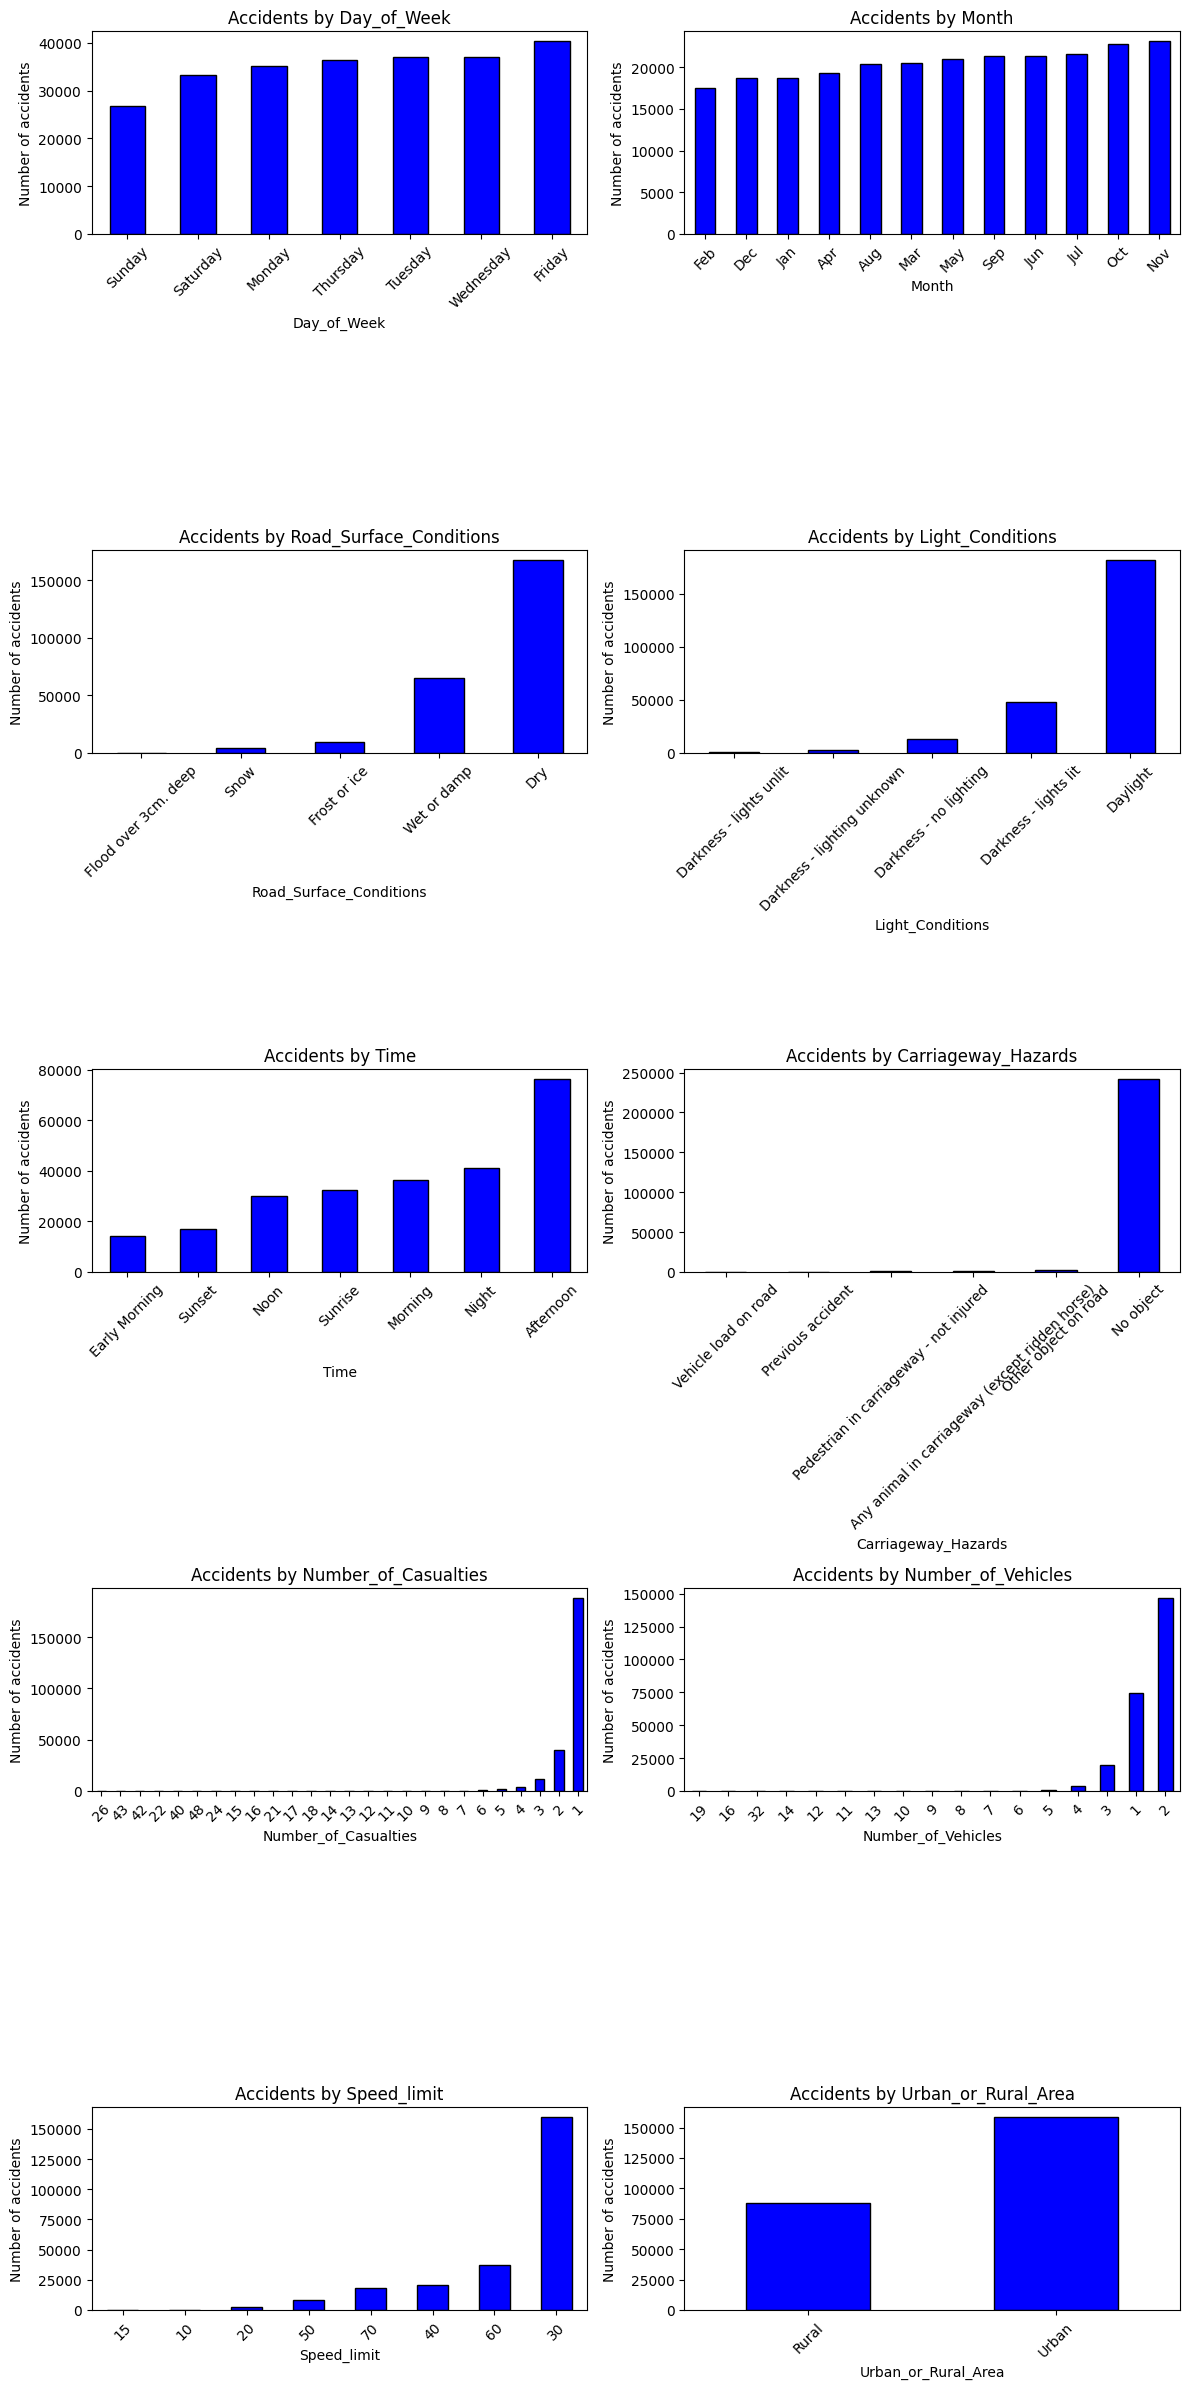

In [13]:
fig, axes = plt.subplots(5, 2, figsize=(12, 24))

variables = ["Day_of_Week", "Month", "Road_Surface_Conditions", "Light_Conditions", "Time", "Carriageway_Hazards",
            "Number_of_Casualties", "Number_of_Vehicles", "Speed_limit", "Urban_or_Rural_Area"]

current_index = 0
for x in range(5):
    for y in range(2):
        tmp = X_train[variables[current_index]].value_counts()
        tmp.sort_values().plot(kind='bar', color='blue', edgecolor='black', ax=axes[x][y])
        axes[x][y].set_xlabel(variables[current_index])
        axes[x][y].set_ylabel("Number of accidents")
        axes[x][y].set_title("Accidents by " + variables[current_index])
        axes[x][y].tick_params(axis='x', rotation=45)
        current_index+=1

plt.tight_layout()

plt.show()

"Accident_Index" is a code that uniquely identifies each accident within our dataset. It does not give any other information, except for the inaccurate location where the accident took place (the code is composed by numbers and two letters, which could be hardly used to get the city or town), but that information can be extracted from the "Longitude" and "Latitude" variables, so we can definitively omit that variable.

In [14]:
X_train = X_train.drop("Accident_Index", axis=1)

X_test = X_test.drop("Accident_Index", axis=1)

Also notice that we only have data from January 1st 2021 to January 1st 2022, so we can not get a relation between the feature "Year" and our target "Accident_Severity". Therefore, we can omit this feature too.

In [15]:
X_train = X_train.drop("Year", axis=1)

X_test = X_test.drop("Year", axis=1)

Furthermore, "Accident Date" column is also redundant, as we already have "Month" and "Day_of_Week" columns. So we can also delete this feature.

In [16]:
X_train = X_train.drop("Accident Date", axis=1)

X_test = X_test.drop("Accident Date", axis=1)

"Local_Authority_(District)" is a variable with a too many unique values, that can introduce noise to our models and do not have any impact on predicting the severity of an accident. So we proceed to delete it as well.

In [17]:
X_train = X_train.drop("Local_Authority_(District)", axis=1)

X_test = X_test.drop("Local_Authority_(District)", axis=1)

It is important to notice that most of our variables are categorical, except for "Speed_limit" (maximum legal speed of the road where the accident took place), "Latitude" and "Longitude", "Number_of_Casualties" and "Number_of_Vehicles".

Tree-based models are usually better to work with categorial features, but as we said, we also want to prove Neural Networks, so we will have to encode all categorical features.

For now, we are going to extract the location (city) where each accident happened from its longitude and latitude, using GeoNames free database (https://www.geonames.org/) and 1-Nearest Neighbour model from SKLearn. The idea is to load a map of the United Kingdom (from which our data belongs) and filter by a 'feature code' so as to obtain only names of important locations of the UK (excluding famous buildings or geographical places, for instance), and filter those cities with less than 100.000 inhabitants. Once we have the data loaded, we apply Ball Tree algorithm to obtain the closest city name to all latitude-longitude pairs. 

In [18]:
# IMPORT GEOGRAPHICAL DATA

column_names = ["geonameid", "name", "asciiname", "alternatenames", "latitude", "longitude",
                "feature_class", "feature_code", "country_code", "cc2", "admin1_code", 
                "admin2_code", "admin3_code", "admin4_code", "population", "elevation", 
                "dem", "timezone", "modification_date"]

geoData = pd.read_csv("GB.txt", sep="\t", header=None, names=column_names, low_memory=False)

geoData = geoData[(geoData['feature_code'].isin(['PPLC', 'PPLA', 'PPLA2'])) & (geoData['population'] > 100000)]

coords = geoData[['latitude', 'longitude']].to_numpy()

# APPLY BALL TREE

nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(coords)

def get_nearest_location(lat, lon, df, nbrs):
    distance, index = nbrs.kneighbors([[lat, lon]])
    return df.iloc[index[0][0]]['name']

# Train data

locations = [get_nearest_location(latitude, longitude, geoData, nbrs) for latitude, longitude in zip(X_train['Latitude'], X_train['Longitude'])]

X_train['Location'] = locations

# Test data

locations = [get_nearest_location(latitude, longitude, geoData, nbrs) for latitude, longitude in zip(X_test['Latitude'], X_test['Longitude'])]

X_test['Location'] = locations

In [19]:
severity_counts = X_train.groupby([X_train['Location'], y_train]).size().unstack(fill_value=0)
plt.figure(figsize=(30, 12))
severity_counts.plot(kind='bar', stacked=False, edgecolor='black', color=['blue', 'orange', 'red'])
plt.xlabel("Location", fontsize=14)
plt.ylabel("Number of accidents", fontsize=14)
plt.title("Accidents by location and severity", fontsize=16)
plt.xticks(rotation=90, ha="center", fontsize=10)
plt.close()
fig = px.bar(severity_counts, barmode='group', color_discrete_sequence=['blue', 'orange', 'red'])
fig.update_layout(
    title="Accidents by location and severity in 2021 in the United Kingdom",
    xaxis_title="Location and severity",
    yaxis_title="Number of accidents",
    xaxis_tickangle=90,
    font=dict(size=14)
)
fig.write_html("accidents_by_location_and_severity.html")
fig.show()

<Figure size 3000x1200 with 0 Axes>

Since we already have our new 'Location' column, we can delete 'Latitude' and 'Longitude' columns.

In [20]:
# Train data

X_train.drop(['Latitude', 'Longitude'], axis=1, inplace=True)

# Test data

X_test.drop(['Latitude', 'Longitude'], axis=1, inplace=True)

Now, it is time to code ordinal categorical variables, those that have values of their domain related by order (including our target).

In [21]:
# Features

days = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
 'Friday': 4, 'Saturday': 5, 'Sunday': 6}

months = {'Jan': 0, 'Feb': 1, 'Mar': 2, 'Apr': 3, 'May': 4, 
 'Jun': 5, 'Jul': 6, 'Aug': 7, 'Sep': 8, 
 'Oct': 9, 'Nov': 10, 'Dec': 11}

day_time = {'Early Morning': 0, 'Sunrise': 1, 'Morning': 2, 'Noon': 3, 
 'Afternoon': 4, 'Sunset': 5, 'Night': 6}

# Encoding train data

X_train["Day_of_Week"] = X_train["Day_of_Week"].apply(lambda x: days[x])
X_train["Month"] = X_train["Month"].apply(lambda x: months[x])
X_train["Time"] = X_train["Time"].apply(lambda x: day_time[x])

# Encoding test data (we assign -1 if any value that we have not codified previously is assigned to any sample)

X_test["Day_of_Week"] = X_test["Day_of_Week"].apply(lambda x: days.get(x, -1))
X_test["Month"] = X_test["Month"].apply(lambda x: months.get(x, -1))
X_test["Time"] = X_test["Time"].apply(lambda x: day_time.get(x, -1)) 

# Target

severity = {'Slight': 0, 'Serious': 1, 'Fatal': 2}

# Train target

y_train = y_train.apply(lambda x: severity[x])

# Test target (same idea as before)

y_test = y_test.apply(lambda x: severity.get(x, -1))

Now, let's codify non-ordinal categorical features using Ordinal Encoder from SKLearn. Ordinal Encoder assigns digits to strings based on the alphabetical order.

In [22]:
encoder = OrdinalEncoder()

Non_Ordinal_Categorical_Features = ["Junction_Control", "Junction_Detail", "Location", "Light_Conditions",
                                    "Carriageway_Hazards", "Police_Force", "Road_Surface_Conditions",
                                    "Road_Type", "Urban_or_Rural_Area", "Weather_Conditions", "Vehicle_Type"]

# Encoding train data 

X_train[Non_Ordinal_Categorical_Features] = encoder.fit_transform(X_train[Non_Ordinal_Categorical_Features])

# Encoding test data

X_test[Non_Ordinal_Categorical_Features] = encoder.transform(X_test[Non_Ordinal_Categorical_Features])

Finally, let's see how distributed our target is.

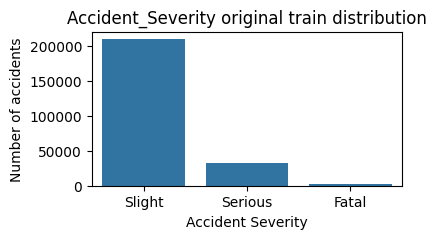

Accident_Severity
0    210462
1     32733
2      3183
Name: count, dtype: int64
Accident_Severity
0    0.854224
1    0.132857
2    0.012919
Name: proportion, dtype: float64


In [23]:
def showTargetDistribution(target):
    plt.figure(figsize=(4, 2))
    sns.countplot(x=target)
    plt.title('Accident_Severity original train distribution')
    plt.ylabel('Number of accidents')
    plt.xlabel("Accident Severity")
    plt.xticks(ticks=[0, 1, 2], labels=['Slight','Serious', 'Fatal'])
    plt.show()

    counts = target.value_counts()
    print(counts)

    proportions = target.value_counts(normalize=True)
    print(proportions)
    
showTargetDistribution(y_train)

Given that our target variable is highly imbalanced—with one class representing 85% of the total samples and another only 0.01%—we will apply the SMOTE technique to address it.

Since SMOTE can introduce noise, we won't fully equalize distributions. Instead, we'll use Tomek Links undersampling to remove ambiguous samples located too close to a decision boundary.

In [24]:
smotenc = SMOTENC(list(X_train.drop(["Number_of_Casualties", "Number_of_Vehicles"], axis=1).columns), random_state=42, 
                  sampling_strategy={1: int(len(y_train[y_train==0])*1.2), 2: int(len(y_train[y_train==0])*1.2)})
X_train_r, y_train_r = TomekLinks().fit_resample(*smotenc.fit_resample(X_train, y_train))

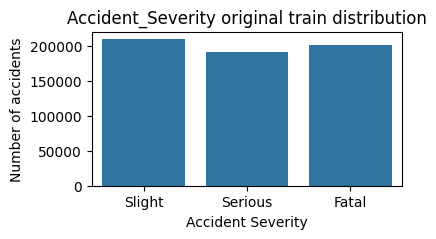

Accident_Severity
0    210462
2    201543
1    192061
Name: count, dtype: int64
Accident_Severity
0    0.348409
2    0.333644
1    0.317947
Name: proportion, dtype: float64


In [25]:
showTargetDistribution(y_train_r)

In [26]:
# Checkpoint

checkpoint_variables = { 
    "X_train": X_train, "X_test": X_test, 
    "y_train": y_train, "y_test": y_test, 
    "X_train_r": X_train_r, "y_train_r": y_train_r 
}

with open("variables.pkl", "wb") as f:
    pickle.dump(checkpoint_variables, f)

In [9]:
with open("variables.pkl", "rb") as f:
    checkpoint_variables = pickle.load(f)

X_train = checkpoint_variables["X_train"]
X_test = checkpoint_variables["X_test"]
y_train = checkpoint_variables["y_train"]
y_test = checkpoint_variables["y_test"]
X_train_r = checkpoint_variables["X_train_r"]
y_train_r = checkpoint_variables["y_train_r"]

### 1. Model Training


#### 1.0 Metric Selection

To develop a model that accurately classifies all three accident severity levels, the F1 score is a suitable metric as it accounts for both precision and recall, ensuring balanced performance across classes. Although accuracy can be used given the balanced dataset, it merely reflects the overall correctness without considering class-wise performance.

Macro F1 is chosen as our main metric, as it calculates the F1 score for each class independently and averages them equally, thus providing an unbiased assessment regardless of minor class size variations.

#### 1.1 XGBoost (Boosting Algorithm)

We are going to start training a XGBoost classifier. The implementation used in this case is extracted from XGBoost library. To obtain the best possible parameters, we are going to use Randomized Search (along with Stratified Shuffle Split), which randomly selects combinations of specified parameter values instead of exhaustively searching over all possible combinations. This approach is more efficient, especially when dealing with a large number of parameters.

In [ ]:
XGBoost_Model = xgb.XGBClassifier(tree_method='hist', device='cpu')

param_dist = {
    'n_estimators': list(np.arange(600, 1551, 10)), # Number of trees
    'max_depth': list(np.arange(1, 16, 10)),  # Maximum depth of trees
    'learning_rate': np.linspace(0.01, 0.5, 10), # Learning rate
    'subsample': np.linspace(0.04, 1.0, 10), # Percentage of samples randomly used to create each tree
    'colsample_bytree': np.linspace(0.04, 0.8, 10), # Percentage of features randomly used to create each tree
    'reg_lambda': np.linspace(0, 3, 10), # L2 Regularization
    'alpha': np.linspace(0.01, 0.8, 10),  # L1 Regularization
}

sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

random_search = RandomizedSearchCV(XGBoost_Model, param_distributions=param_dist, n_iter=10, cv=sss, verbose=3, random_state=42, n_jobs=-1, scoring="f1_macro")
in_time = time.time()
random_search.fit(X_train_r, y_train_r)
print("Total Randomized Search execution time: ", time.time()-in_time)

best_model_XGB = random_search.best_estimator_
best_params_XGB = random_search.best_params_
best_score_XGB = random_search.best_score_

print(f"Best Model: {best_model_XGB}")
print(f"Best Parameters: {best_params_XGB}")
print(f"Best Score: {best_score_XGB}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
XGBoost_Model = xgb.XGBClassifier(num_class=3, objective="multi:softprob", **best_params_XGB, tree_method='hist', device='cpu')
y_pred = cross_val_predict(XGBoost_Model, X_train_r, y_train_r, cv=5)
cm = confusion_matrix(y_train_r, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nReport per class:")
print(classification_report(y_train_r, y_pred))

From the scores and the confusion matrix, we can observe that our XGBoost model is fine detecting "Slight accidents" but not that good when it comes to "Serious" and "Fatal accidents". 

The most probable reason that explains this could be that our model is not learning from the minority classes, so a technique that we could use to combat this situation is calculate specific weights per each class so the XGBoost model can act differently in function of the importance or frequency of each class.

By assigning higher weights to minority classes and lower weights to majority classes, the model will give more focus to the underrepresented classes during training. This helps balance the influence each class has on the loss function, improving the model’s ability to correctly predict minority classes and reducing bias towards the majority class.

In [ ]:
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.5, random_state=7)
y_pred = np.empty_like(y_train_r)

for train_idx, test_idx in sss.split(X_train_r, y_train_r):
    X_tr, X_te = X_train_r.iloc[train_idx], X_train_r.iloc[test_idx]
    y_tr, y_te = y_train_r[train_idx], y_train_r[test_idx]
    current_weights_tr = compute_sample_weight(class_weight='balanced', y=y_tr)

    model = xgb.XGBClassifier(**best_params_XGB, tree_method='hist', device='cpu')
    model.fit(X_tr, y_tr, sample_weight=current_weights_tr)
    
    y_pred[test_idx] = model.predict(X_te)

print(classification_report(y_train_r, y_pred))

As we can see, using specific weights per sample have not been very useful. Indeed, our metrics are even worse. Given that the problem that XGBoost is experimenting is not related to the weightes, let's plot ROC and PR curves, in order to investigate if the problem could be caused by a bad decision threshold.

In [ ]:
def plot_ROC(x_validation, y_validation, model):
    probs = model.predict_proba(x_validation)

    # Model might return a list of arrays. If that is the case, it must be necessary to concatenate them
    if isinstance(probs, list):
        probs = np.vstack([p[:, 1] for p in probs]).T

    # Binarizes y_validation (One-Hot conversion)
    classes = np.unique(y_validation)
    y_bin = label_binarize(y_validation, classes=classes)

    plt.figure(figsize=(8, 6))
    
    # ROC curves for each class
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
        roc_auc = roc_auc_score(y_bin[:, i], probs[:, i])
        plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

    # Micro-average ROC curve (all classes if they were the same)
    fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), probs.ravel())
    roc_auc_micro = roc_auc_score(y_bin, probs, average="micro")
    plt.plot(fpr_micro, tpr_micro, linestyle='--', color='black', 
             label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})')

    plt.title('Multiclass ROC curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

def plot_PR(x_validation, y_validation, model):
    probs = model.predict_proba(x_validation)

    # Model might return a list of arrays. If that is the case, it must be necessary to concatenate them
    if isinstance(probs, list):
        probs = np.vstack([p[:, 1] for p in probs]).T

    classes = np.unique(y_validation)
    y_bin = label_binarize(y_validation, classes=classes)

    plt.figure(figsize=(8, 6))

    # PR curves for each class
    for i, class_label in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_bin[:, i], probs[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'Class {class_label} (AUC = {pr_auc:.2f})')

    # Micro-average PR curve (all classes if they were the same)
    precision_micro, recall_micro, _ = precision_recall_curve(y_bin.ravel(), probs.ravel())
    pr_auc_micro = auc(recall_micro, precision_micro)
    plt.plot(recall_micro, precision_micro, linestyle='--', color='black', 
             label=f'Micro-average PR (AUC = {pr_auc_micro:.2f})')

    plt.title('Multiclass Precision-Recall curves')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

def plot_learning_curves(train_sizes, train_scores, val_scores, scoring, ylim=None):
    #train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure()
    plt.title('Learning curves')
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training set size')
    plt.ylabel(f'{scoring} Score')
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation score')
    plt.legend(loc='best')
    plt.show()

In order to plot curves, let's first do a quick and simple cross validation, using the best parameters found previously (they already are being used in XGBoost_Model).

In [ ]:
X_train_r_CURVES, X_validation_r_CURVES, y_train_r_CURVES, y_validation_r_CURVES = train_test_split(X_train_r, y_train_r, test_size=0.2, random_state=42)
XGBoost_Model.fit(X_train_r_CURVES, y_train_r_CURVES)
y_pred_CURVES = XGBoost_Model.predict(X_validation_r_CURVES)
print(classification_report(y_validation_r_CURVES, y_pred_CURVES))

In [ ]:
plot_ROC(X_validation_r_CURVES, y_validation_r_CURVES, XGBoost_Model)
plot_PR(X_validation_r_CURVES, y_validation_r_CURVES, XGBoost_Model)

From the learning curves plot above, we can extract the following information:

- XGBoost model can easily distinguish whether an accident has a slight severity or not and it does not usually fail classifying it (high AUC for Class 0 both ROC and PR curves, 0.97 and 0.91 respectively).

- XGBoost model has serveral problems classifying both severe and fatal accidents, as we see that AUC-ROC and, specially, AUC-PR metrics are much worse than for slight accidents.

- Decision threshold for XGBoost model is pretty accurated, as PR curve does not show any point (any threshold) which can lead to a better trade-off between Precision and Recall for any class.

In [ ]:
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=7)
train_sizes, train_scores, val_scores = learning_curve(XGBoost_Model, X_train_r, y_train_r, cv=sss, 
                                                       scoring='f1_macro', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
plot_learning_curves(train_sizes, train_scores, val_scores, 'f1_macro')

Note that the performance on the training set is only slightly higher than on the validation set. This indicates that our model is not highly overfitting the training data.

Also, when the model is trained on the entire dataset, its performance remains stable (indeed, it starts to decrease). This suggests that the current number of samples is sufficient and that adding more data is unlikely to yield significant improvements in performance.

#### 1.2 Multilayer Perceptron (Neural Network)

Now, let's try with a Neuronal Network (Multilayer perceptron, which is a fully connected feedforward network used for classification and regression), implemented with Pytorch.

But first, we will have to encode our data using One Hot Encoder. It is important to use One Hot encoding because Neural Networks do not understand categorical variables numerically codified, except if they are binary.

Also, numerical features should be standarized ("Number_of_Casualties" and "Number_of_Vehicles"). 

In [10]:
enc = OneHotEncoder(sparse_output=True)

X_train_r_OneHot = enc.fit_transform(X_train_r.drop(['Number_of_Casualties', 'Number_of_Vehicles'], axis=1))

X_train_r_OneHot = pd.DataFrame(X_train_r_OneHot.toarray(), columns=enc.get_feature_names_out())

X_train_r_OneHot.reset_index(drop=True, inplace=True)

X_train_r_Numeric = X_train_r[['Number_of_Casualties', 'Number_of_Vehicles']].reset_index(drop=True)

stdScaler = StandardScaler()
X_train_r_Numeric_scaled = pd.DataFrame(stdScaler.fit_transform(X_train_r_Numeric), columns=X_train_r_Numeric.columns, index=X_train_r_Numeric.index)

X_train_r_OneHot = pd.concat([X_train_r_Numeric_scaled, X_train_r_OneHot], axis=1)

print(X_train_r_OneHot.describe())

       Number_of_Casualties  Number_of_Vehicles        Month_0        Month_1  \
count          6.040660e+05        6.040660e+05  604066.000000  604066.000000   
mean          -6.022486e-17       -1.264722e-16       0.081920       0.078147   
std            1.000001e+00        1.000001e+00       0.274243       0.268403   
min           -4.450112e-01       -9.733940e-01       0.000000       0.000000   
25%           -4.450112e-01       -9.733940e-01       0.000000       0.000000   
50%           -4.450112e-01        2.826818e-01       0.000000       0.000000   
75%            3.461387e-01        2.826818e-01       0.000000       0.000000   
max            3.673903e+01        3.796496e+01       1.000000       1.000000   

             Month_2        Month_3        Month_4        Month_5  \
count  604066.000000  604066.000000  604066.000000  604066.000000   
mean        0.082782       0.081082       0.084001       0.084540   
std         0.275553       0.272962       0.277389       0.2781

Important note: In case Neural Network model does better in validation tests than any other model, we will have to apply this same previous process to X_test data, in order to get a final performance.

Let's define our Neural Network using Pytorch framework.

Our Network will use Adam optimizer (which combines both Momentum and RMSProp, what makes it highly used) and Batch Normalization (it helps Adam to find quicker and better optimums).

The list of hyperparameters we want to optimize is as follows:

- Number of layers
- Number of neurons per layer
- Activation function
- Number of epochs
- Batch size
- Learning Rate
- Weights initialization
- L2 Regularization (weight decays)
- Dropout rate
- Loss function

To have it into account, the parameters our Network will internally optimize are:

- Weights of each input, per neuron and per layer.
- γ and 𝛽, for Batch Normalization.

To reduce the search space, we are going to fix the number of epochs to 50 and use Cross-Entropy Loss as loss function.

In [11]:
class NeuralNetwork_Classifier(nn.Module):
    def __init__(self, *, n_nodes_layer: list, activation_function: str, dropout_rate: float, 
                 init_method: str, learning_rate: float, L2_reg: float, criterion: str = "CrossEntropyLoss"):
        super(NeuralNetwork_Classifier, self).__init__()

        self.activation_fn = activation_function
        self.init_method = init_method
        
        # n_nodes_layer[0] equals the number of features
        # n_nodes_layer[-1] equals the number of possible classes
        
        self.layers = nn.ModuleList()

        for i in range(1, len(n_nodes_layer)-1):
            layer = nn.Sequential(
                nn.Linear(n_nodes_layer[i-1], n_nodes_layer[i], bias=False), # bias is not necessary when using batch norm
                nn.BatchNorm1d(n_nodes_layer[i]),
                self.apply_activation(),
                nn.Dropout(dropout_rate)
            )

            self.layers.append(layer)

        self.layers.append(nn.Linear(n_nodes_layer[-2], n_nodes_layer[-1]))

        self.apply(self._init_weights)
        self.criterion = nn.CrossEntropyLoss() if criterion == "CrossEntropyLoss" else nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=L2_reg)

    def apply_activation(self) -> nn.Module:
        act = self.activation_fn.lower()
        
        if act == "relu":
            return nn.ReLU()
        elif act == "leaky_relu":
            return nn.LeakyReLU()
        elif act == "gelu":
            return nn.GELU()
        elif act in ["swish", "silu"]:
            return nn.SiLU()
        else:
            raise ValueError(f"Unknown activation function: {act}")

    def _init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            if self.init_method == "uniform":
                nn.init.uniform_(layer.weight, a=-0.1, b=0.1)
            elif self.init_method == "normal":
                nn.init.normal_(layer.weight, mean=0.0, std=0.02)
            elif self.init_method == "constant":
                nn.init.constant_(layer.weight, 0)
            elif self.init_method == "xavier":
                nn.init.xavier_uniform_(layer.weight)
            else:
                raise ValueError(f"Unknown initialization method: {self.init_method}")
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # For each hidden layer, compute output and activation function
        for layer in self.layers[:-1]:
            x = layer(x)

        x = self.layers[-1](x) # No Sigmoid activation needed
        
        return x

    def predict(self, X):
        was_training = self.training
        self.eval()
        
        with torch.no_grad():
            logits = self.forward(X)
            predictions = torch.argmax(logits, dim=1)
            
        if was_training:
            self.train()
        return predictions


    def fit(self, dataloader, n_epochs: int, device:str ="cpu"):
        self.train()
        self.to(device)
        
        for epoch in range(n_epochs):
            total_loss = 0

            for X_batch, y_batch in dataloader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                self.optimizer.zero_grad()
                output = self(X_batch) # OUTPUT ARE LOGITS, WE ARE NOT USING SOFTMAX IN THE OUTPUT LAYER, SOFTMAX IS APPLIED BY CrossEntropyLoss
                loss = self.criterion(output, y_batch)
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
            
            print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")


In [12]:
# DEVICE DEFINITION
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(f"Using: {device}")

# SEARCH PARAMETERS
hparams = {}
hparams["n_hidden_layers"] = np.arange(1, 7, 1)
hparams["max_nodes_hidden_layer"] = np.pow(2, np.arange(4, 15))
hparams["learning_rate"] = np.logspace(-4, 2, num=10)
hparams["batch_size"] = np.pow(2, np.arange(5, 9))
hparams["activation_function"] = ["relu", "leaky_relu", "gelu", "swish"]
hparams["weights_initialization"] = ["uniform", "normal", "constant", "xavier"]
hparams["L2_reg"] = np.logspace(-5, 0, num=10)
hparams["dropout_rate"] = np.linspace(0, 0.7, num=8)

# CONSTANT PARAMETERS
n_epochs = 5
n_input_nodes = X_train_r_OneHot.shape[1]

# FUNCTIONS THAT GENERATES NN ARCHITECTURES
def generate_architecture(max_nodes_hidden_layer: int, n_hidden_layers: int, n_input_nodes: int, n_classes: int) -> list:
    n_nodes_layer = [n_input_nodes]
    current_n_nodes = max_nodes_hidden_layer
    for _ in range(n_hidden_layers):
        n_nodes_layer.append(int(current_n_nodes))
        current_n_nodes = (current_n_nodes/2) if current_n_nodes > 2 else 2
    n_nodes_layer.append(n_classes)
    return n_nodes_layer

def generate_fixed_architectures():
    architectures = [[2018,2048,1640,1024,720,402,256,32,16,3]]
    for architecture in architectures:
        yield architecture

Using: cpu


In [ ]:
def random_search(*, X, y, hparams: dict, n_epochs: int, n_iters: int, n_input_nodes: int) -> (dict, dict):
    sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

    best_NN_model = None
    best_score = 0
    global_scores = []

    X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y.values, dtype=torch.long).to(device)
    
    def get_param_combs() -> list:
        values = [hparams[k] for k in keys]
        
        all_combinations = list(product(*values))
        
        return random.sample(all_combinations, n_iters)

    keys = list(hparams.keys())
    random_combs = get_param_combs()
    
    for combo in random_combs:
        current_params = dict(zip(keys, combo))
        
        n_hidden_layers = current_params["n_hidden_layers"]
        max_nodes_hidden_layer = current_params["max_nodes_hidden_layer"]
        learning_rate = current_params["learning_rate"]
        batch_size = current_params["batch_size"]
        activation_function = current_params["activation_function"]
        weights_initialization = current_params["weights_initialization"]
        L2_reg = current_params["L2_reg"]
        dropout_rate = current_params["dropout_rate"]
        
        n_nodes_layer = generate_architecture(max_nodes_hidden_layer, n_hidden_layers, n_input_nodes, 3)
        
        print("Training model using:", ", ".join([f"{k}={v}" for k, v in current_params.items()]), "\n")
        print("Network architecture:", n_nodes_layer, "\n")
        
        local_scores = []
        for train_index, test_index in sss.split(X, y):
            model = NeuralNetwork_Classifier(n_nodes_layer=n_nodes_layer, activation_function=activation_function, dropout_rate=dropout_rate,
                                             init_method=weights_initialization, learning_rate=learning_rate, L2_reg=L2_reg)

            X_train = X_tensor[train_index]
            y_train = y_tensor[train_index]
            
            X_validation = X_tensor[test_index]

            dataset = TensorDataset(X_train, y_train)
            dataloader = DataLoader(dataset, batch_size=int(batch_size), shuffle=True, num_workers=4, pin_memory=True if device=='cuda' else False)

            model.fit(dataloader, n_epochs)
            
            y_pred = model.predict(X_validation)
            y_pred = y_pred.cpu().numpy()

            current_f1 = f1_score(y.iloc[test_index].values, y_pred, average="macro")
            local_scores.append(current_f1)
            print(f"F1 macro: {current_f1}", "\n")

        comb_score = np.mean(local_scores)
        if comb_score > best_score:
            best_score = comb_score
            best_NN_model = model

        global_scores.append(np.mean(local_scores))
        print(f"FINAL CURRENT COMBINATION F1 MACRO MEAN: {comb_score}\n")

    return best_NN_model, global_scores

random_search(X=X_train_r_OneHot, y=y_train_r, hparams=hparams, n_epochs=n_epochs, n_iters=3, n_input_nodes=n_input_nodes)

Training model using: n_hidden_layers=4, max_nodes_hidden_layer=512, learning_rate=0.002154434690031882, batch_size=64, activation_function=leaky_relu, weights_initialization=constant, L2_reg=0.0004641588833612782, dropout_rate=0.09999999999999999 

Network architecture: [218, 512, 256, 128, 64, 3] 

Epoch 1, Loss: 1.0980121575669886
Epoch 2, Loss: 1.0980182033929584
